# Vehicle Detection and Tracking
## 0. Import Packages

In [1]:
import cv2
import glob
import time
import pickle
import numpy as np
import seaborn as sns

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

from moviepy.editor import VideoFileClip
from IPython.display import HTML

## 1. Lesson Functions

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [3]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## 2. Histogram of Oriented Gradients (HOG) Feature Extraction on a Labeled Training Set of              Images and Training Linear SVM Classifier



In [4]:
# Read in cars and notcars
vehicles = glob.glob('images/vehicles/*/*.png')
non_vehicles = glob.glob('images/non-vehicles/*/*.png')


print("Loading", len(vehicles), "vehicle images...")
print("Loading", len(non_vehicles), "non-vehicle images...")

cars = []
notcars = []
for image in non_vehicles:
    notcars.append(image)
for image in vehicles:
    cars.append(image)

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

Loading 8792 vehicle images...
Loading 8968 non-vehicle images...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
18.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


 No. of features for pix_per_cell-  8 cell_per_block - 1 is 576
 No. of features for pix_per_cell-  16 cell_per_block - 1 is 144
 No. of features for pix_per_cell-  8 cell_per_block - 2 is 1764
 No. of features for pix_per_cell-  16 cell_per_block - 2 is 324


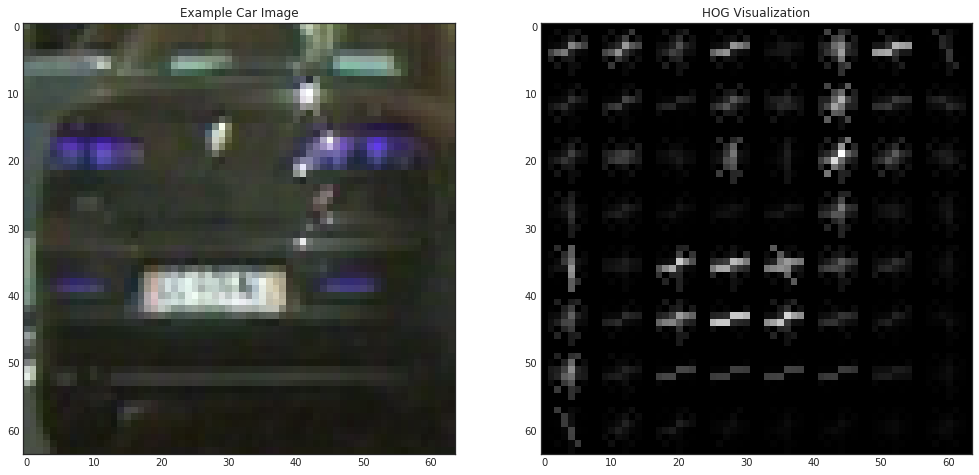

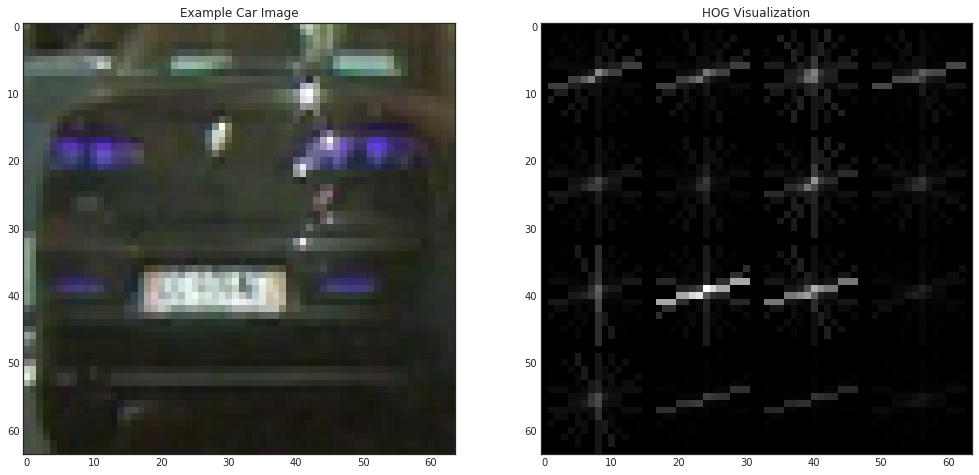

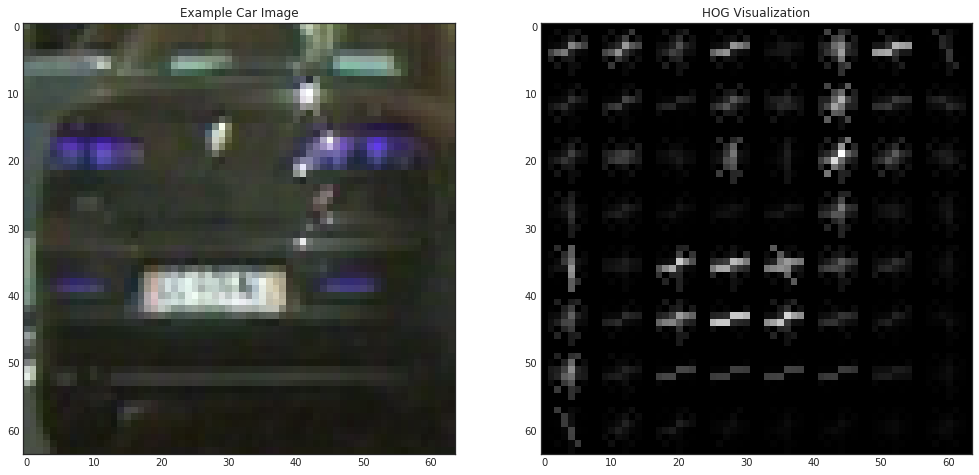

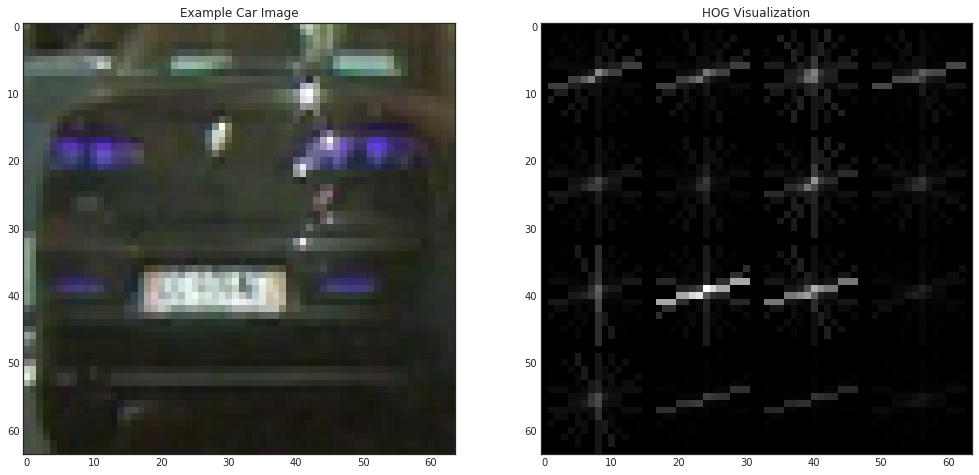

In [5]:
# Extract hog features and display
pix_per_cell = [8,16,8,16]
cell_per_block = [1,1,2,2]
orient = [9,9,9,9]

for i in range(len(pix_per_cell)):
# Input is an image of single channel or gray
    car_ind = 1167
    car_image = cv2.imread(cars[car_ind])

    gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)
    features, hog_image = get_hog_features(gray, orient[i], pix_per_cell[i], cell_per_block[i],
                             vis=True, feature_vec=False)
    feature_flatten = features.ravel()
    # If feature_vector=True then hog will automatically ravel

    # Plot the examples
    with sns.axes_style("white"):
        fig = plt.figure(figsize=(17, 17))
        plt.subplot(121)
        plt.imshow(car_image, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        print(" No. of features for pix_per_cell- ", pix_per_cell[i], "cell_per_block -", cell_per_block[i], "is", 
              len(feature_flatten))

 No. of features for pix_per_cell-  8 cell_per_block - 1 is 576
 No. of features for pix_per_cell-  16 cell_per_block - 1 is 144
 No. of features for pix_per_cell-  8 cell_per_block - 2 is 1764
 No. of features for pix_per_cell-  16 cell_per_block - 2 is 324


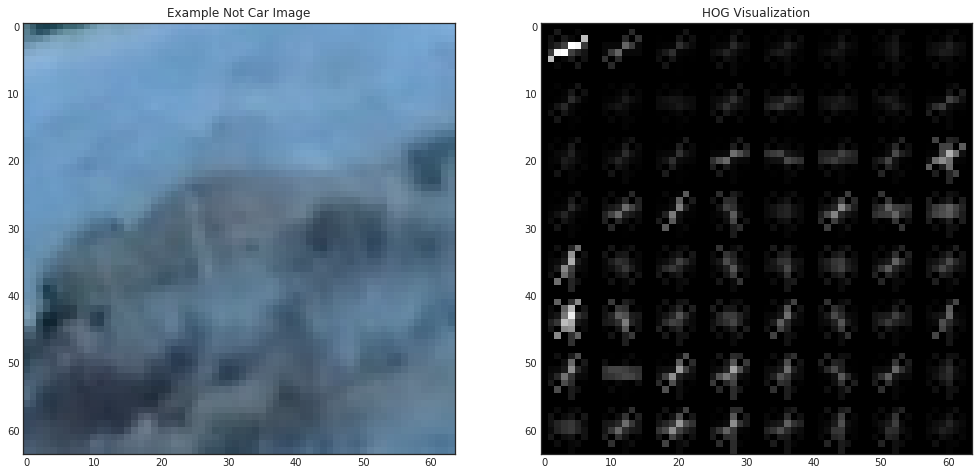

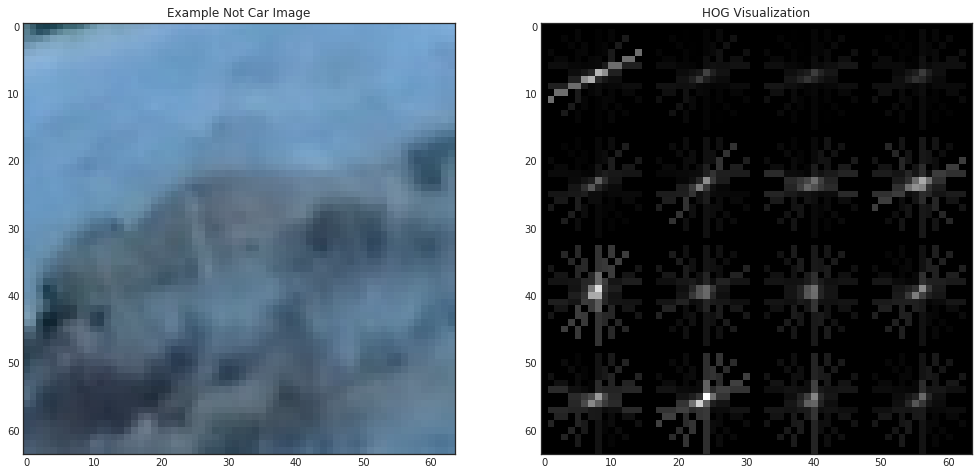

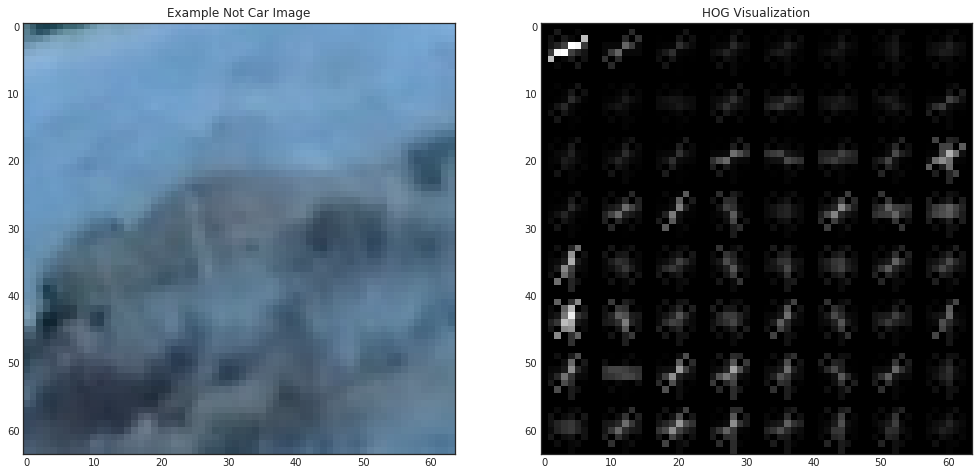

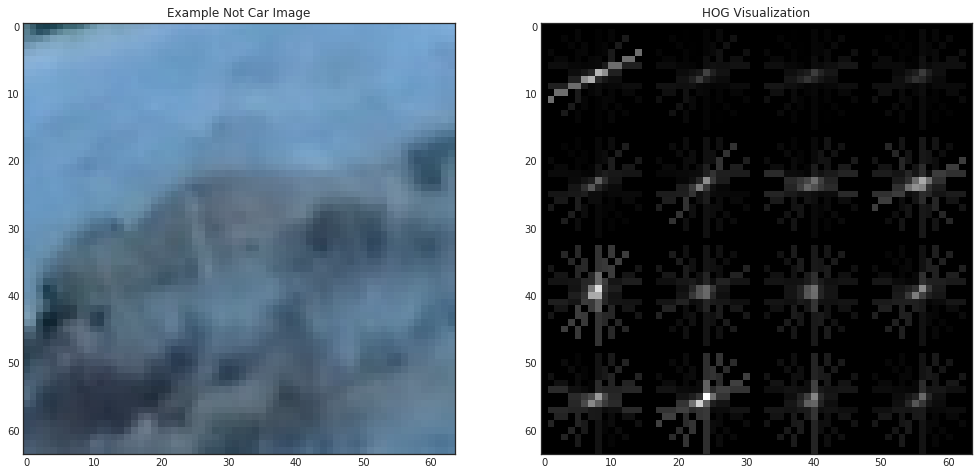

In [6]:
# Extract hog features and display
pix_per_cell = [8,16,8,16]
cell_per_block = [1,1,2,2]
orient = [9,9,9,9]

for i in range(len(pix_per_cell)):
# Input is an image of single channel or gray
    car_ind = 1167
    car_image = cv2.imread(notcars[car_ind])

    gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)
    features, hog_image = get_hog_features(gray, orient[i], pix_per_cell[i], cell_per_block[i],
                             vis=True, feature_vec=False)
    feature_flatten = features.ravel()
    # If feature_vector=True then hog will automatically ravel

    # Plot the examples
    with sns.axes_style("white"):
        fig = plt.figure(figsize=(17, 17))
        plt.subplot(121)
        plt.imshow(car_image, cmap='gray')
        plt.title('Example Not Car Image')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        print(" No. of features for pix_per_cell- ", pix_per_cell[i], "cell_per_block -", cell_per_block[i], "is", 
              len(feature_flatten))

## 3. Implement a Sliding-Window Technique and use the Trained Classifier to search for cars in images.



In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, 
                                                          hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw + ystart),(xbox_left+win_draw,ytop_draw + win_draw + ystart)))
    return bboxes

## 4. Run the Data Pipeline on a Video Stream (test_video.mp4 and project_video.mp4)  and create a Heat Map of recurring Detections frame by frame to reject Outliers and follow Detected Cars



In [8]:
def process_image(image):
    global last_bboxes
    
    bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    last_bboxes.append(bboxes)
    last_bboxes = last_bboxes[-10:]
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, [bbox for bboxes in last_bboxes for bbox in bboxes])

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img


In [9]:
print ("ystart = " , ystart)

last_bboxes = []

project_output_file = "test_output.mp4"

project_video = VideoFileClip("test_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

NameError: name 'ystart' is not defined

In [ ]:
HTML("""
<video width="980" height="550" controls>
  <source src="{0}">
</video>
""".format(project_output_file))

In [ ]:
print ("ystart = " , ystart)

last_bboxes = []

project_output_file = "project_output.mp4"

project_video = VideoFileClip("project_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

In [ ]:
HTML("""
<video width="980" height="550" controls>
  <source src="{0}">
</video>
""".format(project_output_file))

## 5. Estimate a Bounding Box for Cars detected



In [ ]:
files = ['test_images/test1.jpg','test_images/test2.jpg','test_images/test3.jpg','test_images/test4.jpg',
         'test_images/test5.jpg','test_images/test6.jpg']

for file in files:

    ystart = 400
    ystop = 656
    scale = 1.5

    image = mpimg.imread(file)
    box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins)

# Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(17, 17))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions',fontsize=20)
    plt.subplot(122)

    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map',fontsize=20)
    fig.tight_layout()
